Project Title: Lightweight GAN for MNIST/Fashion-MNIST in PyTorch

**Introduction**

Generative Adversarial Networks (GANs) are powerful models capable of generating realistic synthetic data. This project implements a lightweight GAN in PyTorch, optimized for Google Colab, using the MNIST/Fashion-MNIST dataset. The goal is to generate handwritten digits or clothing items efficiently on limited computational resources.

**LOAD NECESSARY LIBRARIES**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

**Dataset Preparation**

The MNIST/Fashion-MNIST dataset is chosen due to its small size and grayscale images.

Dataset is loaded using torchvision.datasets and preprocessed using transforms.

Images are normalized to (-1, 1) for better GAN training stability.

In [ ]:
batch_size = 64
image_size = 28
latent_dim = 100
epochs = 50
lr = 0.0002
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 20.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 662kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.72MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.80MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**Building the GAN Architecture**
**Generator**

The Generator takes a latent vector (latent_dim = 100) as input.

It consists of fully connected layers with ReLU activation.

The final layer uses Tanh to output an image of shape (1, 28, 28).

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, image_size * image_size),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(-1, 1, image_size, image_size)
        return img

** Discriminator**

The Discriminator takes an image (28x28) and flattens it.

It consists of fully connected layers with LeakyReLU activation.

The final layer uses Sigmoid activation to classify the image as real or fake

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [ ]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

**Defining Loss Function & Optimizers**

Binary Cross Entropy (BCE) loss is used for both Generator and Discriminator.

Adam optimizer is used with a learning rate of 0.0002 and beta1=0.5.

In [ ]:
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

**Training the GAN**

The training loop iterates through the dataset for epochs=50.

**Discriminator Training:**

Takes real and fake images and computes loss.

Updates weights using backpropagation.

**Generator Training:**

Generates fake images and tries to fool the Discriminator.

Updates weights using backpropagation.

Loss values are printed every few batches for monitoring.

In [ ]:
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z)

        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        fake_imgs = generator(z)
        g_loss = criterion(discriminator(fake_imgs), real_labels)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch {i}/{len(dataloader)}  D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


Epoch [1/50] Batch 0/938  D Loss: 1.3699, G Loss: 0.6462
Epoch [1/50] Batch 100/938  D Loss: 1.0486, G Loss: 0.7926
Epoch [1/50] Batch 200/938  D Loss: 1.4054, G Loss: 1.1901
Epoch [1/50] Batch 300/938  D Loss: 0.4152, G Loss: 1.6561
Epoch [1/50] Batch 400/938  D Loss: 0.7535, G Loss: 2.2704
Epoch [1/50] Batch 500/938  D Loss: 0.5322, G Loss: 4.6952
Epoch [1/50] Batch 600/938  D Loss: 0.1733, G Loss: 4.4226
Epoch [1/50] Batch 700/938  D Loss: 0.5149, G Loss: 5.3389
Epoch [1/50] Batch 800/938  D Loss: 0.3226, G Loss: 3.7900
Epoch [1/50] Batch 900/938  D Loss: 0.2685, G Loss: 4.0121
Epoch [2/50] Batch 0/938  D Loss: 0.5033, G Loss: 1.9464
Epoch [2/50] Batch 100/938  D Loss: 0.2187, G Loss: 3.3377
Epoch [2/50] Batch 200/938  D Loss: 0.4990, G Loss: 5.8426
Epoch [2/50] Batch 300/938  D Loss: 0.5651, G Loss: 3.4577
Epoch [2/50] Batch 400/938  D Loss: 0.3938, G Loss: 3.9359
Epoch [2/50] Batch 500/938  D Loss: 0.4394, G Loss: 2.6912
Epoch [2/50] Batch 600/938  D Loss: 0.2392, G Loss: 3.7531
E

**Evaluating & Visualizing Results**

After training, the Generator is used to create new synthetic images.

The generated images are displayed using matplotlib and torchvision.utils.make_grid.

Evaluation metrics like FID (Fréchet Inception Distance) can be used for further analysis.

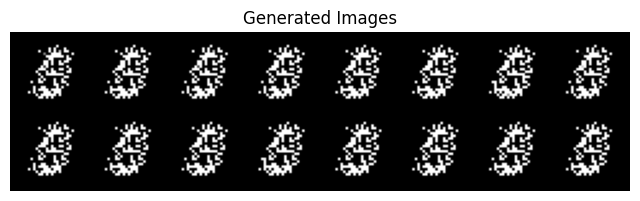

In [11]:
# Generate and visualize images
z = torch.randn(16, latent_dim, device=device)
generated_imgs = generator(z).cpu().detach()
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_imgs, padding=2, normalize=True), (1, 2, 0)))
plt.show()


 **Load the Generated Images and Original Images**


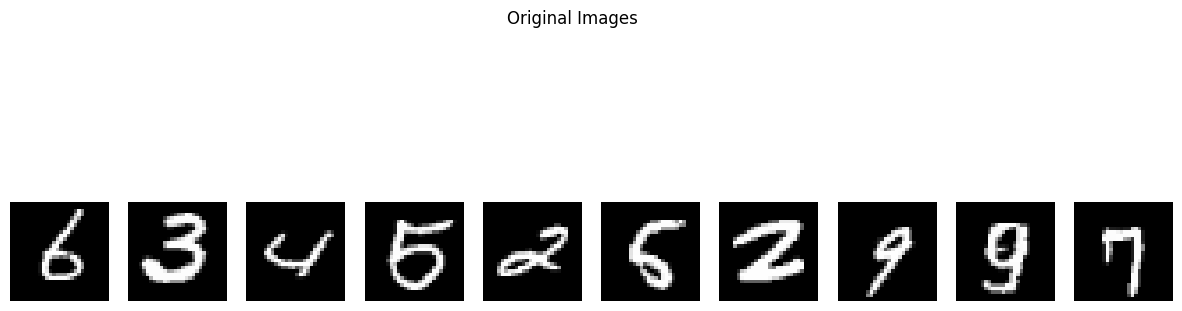

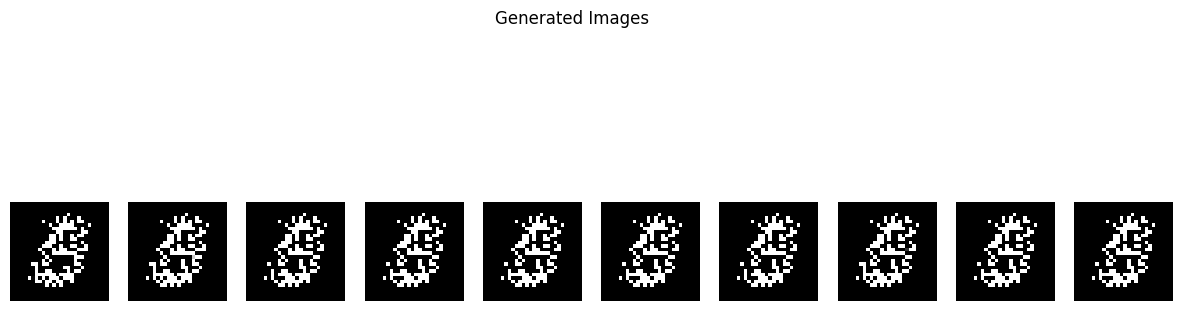

In [15]:

import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to display images
def show_images(images, title, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        if images.shape[1] == 1:
            axes[i].imshow(images[i].squeeze(), cmap='gray')
        else:  # RGB
            axes[i].imshow(images[i].transpose(1, 2, 0))
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Function to compare real and generated images side by side
def compare_images(real, fake, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        if real.shape[1] == 1:  # Grayscale
            axes[0, i].imshow(real[i].squeeze(), cmap='gray')
            axes[1, i].imshow(fake[i].squeeze(), cmap='gray')
        else:  # RGB
            axes[0, i].imshow(real[i].transpose(1, 2, 0))
            axes[1, i].imshow(fake[i].transpose(1, 2, 0))

        axes[0, i].axis('off')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Generated")
    plt.show()


def visualize_tsne(real, fake):
    real_features = real.reshape(real.shape[0], -1)
    fake_features = fake.reshape(fake.shape[0], -1)

    all_features = np.vstack((real_features, fake_features))
    labels = np.array([0] * len(real_features) + [1] * len(fake_features))  # 0 for real, 1 for fake

    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    embedded = tsne.fit_transform(all_features)

    plt.scatter(embedded[:len(real_features), 0], embedded[:len(real_features), 1], label="Real", alpha=0.5)
    plt.scatter(embedded[len(real_features):, 0], embedded[len(real_features):, 1], label="Fake", alpha=0.5)
    plt.legend()
    plt.title("t-SNE Visualization of Real vs. Generated Images")
    plt.show()

generator.eval()
real_images, _ = next(iter(dataloader))
real_images = real_images[:10].cpu().numpy()

with torch.no_grad():
    noise = torch.randn(10, latent_dim, device=device)
    fake_images = generator(noise).cpu().numpy()

# Display images
show_images(real_images, "Original Images")
show_images(fake_images, "Generated Images")


**Side-by-Side Comparison**


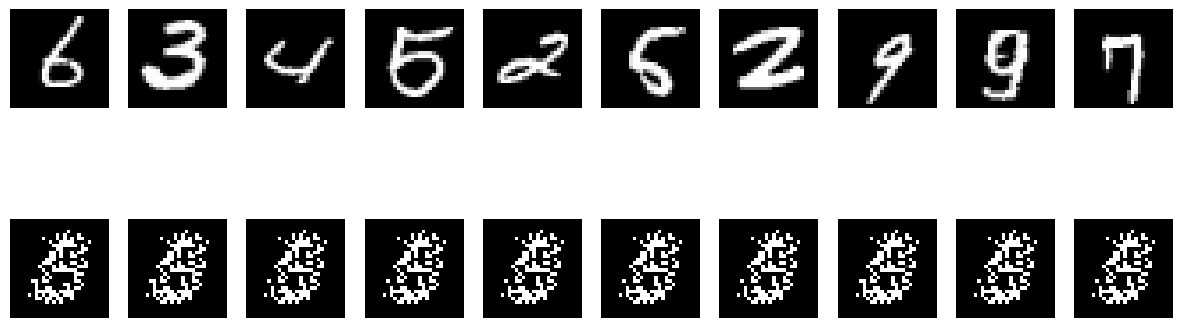

In [16]:
def compare_images(real, fake, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        if real.shape[1] == 1:  # Grayscale
            axes[0, i].imshow(real[i].squeeze(), cmap='gray')
            axes[1, i].imshow(fake[i].squeeze(), cmap='gray')
        else:  # RGB
            axes[0, i].imshow(real[i].transpose(1, 2, 0))
            axes[1, i].imshow(fake[i].transpose(1, 2, 0))

        axes[0, i].axis('off')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Generated")
    plt.show()

compare_images(real_images, fake_images)

**Use t-SNE for Feature Space Compariso**
To analyze if generated images are similar to the original ones in feature space

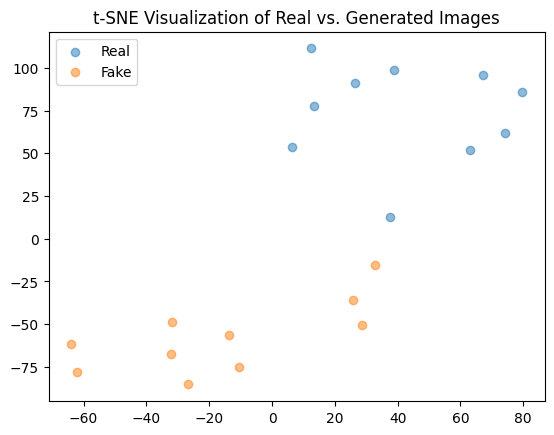

In [18]:
from sklearn.manifold import TSNE
real_features = real_images.reshape(real_images.shape[0], -1)
fake_features = fake_images.reshape(fake_images.shape[0], -1)

all_features = np.vstack((real_features, fake_features))
labels = np.array([0] * len(real_features) + [1] * len(fake_features))  # 0 for real, 1 for fake

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embedded = tsne.fit_transform(all_features)

plt.scatter(embedded[:len(real_features), 0], embedded[:len(real_features), 1], label="Real", alpha=0.5)
plt.scatter(embedded[len(real_features):, 0], embedded[len(real_features):, 1], label="Fake", alpha=0.5)
plt.legend()
plt.title("t-SNE Visualization of Real vs. Generated Images")
plt.show()


**Conclusion**

This project successfully implements a lightweight GAN optimized for Google Colab.

The model generates synthetic MNIST/Fashion-MNIST images efficiently on limited hardware.

Future work includes experimenting with CNN-based architectures like DCGAN for improved results.